In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

In [2]:

import deeptrack as dt
import numpy as np
import skimage.color
import matplotlib.pyplot as plt

In [3]:
available_shapes = {"point", "sphere", "annulus", "ellipse", "moon"}

shape_to_train_on = "annulus"
shape_to_evaluate_on = "annulus"

assert shape_to_train_on in available_shapes, f"{shape_to_train_on} is not a valid shape"
assert shape_to_evaluate_on in available_shapes, f"{shape_to_train_on} is not a valid shape"

In [4]:
class Annulus(dt.Ellipse):

    __conversion_table__ = dt.ConversionTable(
        outer_radius=(dt.units.pixel, dt.units.pixel),
        inner_radius=(dt.units.pixel, dt.units.pixel)
    )

    def get(self, *inp, inner_radius, radius, **kwargs):
        
        im0 = super().get(*inp, radius=radius, **kwargs)
        reduced = dt.Affine(scale=inner_radius / radius, mode="constant")(im0)
        return im0 - reduced


class CrescentMoon(dt.Ellipse):
    __conversion_table__ = dt.ConversionTable(
        radius=(dt.units.pixel, dt.units.pixel),
        offset=(dt.units.pixel, dt.units.pixel)
    )
    def get(self, *inp, radius, offset, **kwargs):
        ellipse = super().get(*inp, radius=radius, **kwargs)
        offset = np.round(offset).astype(np.int)
        other = dt.Affine(translate=offset, mode="constant").resolve(ellipse)
        ellipse[np.array(other > 0)] = 0

        return ellipse


In [5]:
arguments = dt.Arguments(
    particle_shape = shape_to_train_on, 
    position=lambda: np.random.uniform(27, 37, 2),
    snr=lambda: np.random.uniform(2, 20)
)
optics = dt.Fluorescence(output_region=(0, 0, 64, 64))

In [6]:
point = dt.PointParticle(position=arguments.position)
sphere = dt.Sphere(position=arguments.position, radius=1*dt.units.micrometer)
annulus = Annulus(
    radius=12 * dt.units.px,
    inner_radius= 8 * dt.units.px,
    position=arguments.position,
)
ellipse = dt.Ellipse(
    position=arguments.position,
    radius=(12, 7, 3) * dt.units.px,
)
moon = CrescentMoon(
    radius=1 * dt.units.micrometer,
    offset=(6, 0),
    position=arguments.position,
)

particle = dt.OneOfDict(
    dict(
        point=point,
        sphere=sphere, 
        annulus=annulus, 
        ellipse=ellipse, 
        moon=moon
    ),
    key=arguments.particle_shape
)

<AxesSubplot:>

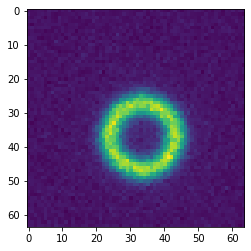

In [7]:
data_pipeline = (
    optics(particle) 
    >> dt.NormalizeMinMax()
    >> dt.Affine(rotate=lambda: np.random.uniform(0, 2 * np.pi))
    >> dt.Add(0.1)
    >> dt.Poisson(snr=arguments.snr)
).bind_arguments(arguments)

data_pipeline.plot()

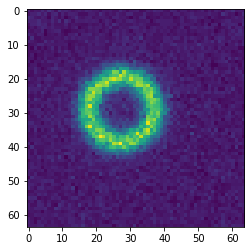

In [8]:
training_sample = data_pipeline.update()(snr=10)
plt.imshow(training_sample)
plt.show()

In [9]:
model = dt.models.AutoMultiTracker(input_shape=(None, None, 1))
model.fit(dt.Value(np.array(training_sample)), epochs=30, batch_size=8)

Generating 163 / 160 samples before starting training
Epoch 1/30
163/163 [==============================] - 4s 8ms/step - total_loss: 1.5780 - consistency_loss: 1.0994
Epoch 2/30
163/163 [==============================] - 1s 8ms/step - total_loss: 0.7884 - consistency_loss: 0.6330
Epoch 3/30
163/163 [==============================] - 1s 8ms/step - total_loss: 0.2672 - consistency_loss: 0.1723
Epoch 4/30
163/163 [==============================] - 1s 8ms/step - total_loss: 0.0566 - consistency_loss: 0.0114
Epoch 5/30
163/163 [==============================] - 1s 8ms/step - total_loss: 0.0340 - consistency_loss: 0.0060
Epoch 6/30
163/163 [==============================] - 1s 8ms/step - total_loss: 0.0373 - consistency_loss: 0.0057
Epoch 7/30
163/163 [==============================] - 1s 8ms/step - total_loss: 0.0346 - consistency_loss: 0.0053
Epoch 8/30
163/163 [==============================] - 1s 8ms/step - total_loss: 0.0301 - consistency_loss: 0.0051
Epoch 9/30
163/163 [==============

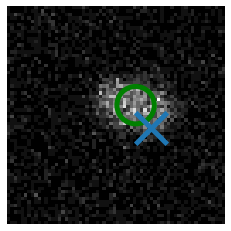

In [10]:
validation_data = data_pipeline.update()(particle_shape="ellipse")
ground_truth_position = validation_data.get_property("position") 

prediction = model.predict_and_pool(validation_data[np.newaxis])

plt.imshow(validation_data, cmap="gray")
plt.scatter(ground_truth_position[1], ground_truth_position[0], s=1400, linewidths=5, marker="o", facecolors="none", edgecolors="g")
plt.scatter(prediction[0, 1], prediction[:, 0], s=1000, linewidths=5, marker="x")
plt.axis("off")
plt.show()